In [1]:

from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from scipy.stats import expon
import pandas as pd
import numpy as np


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import cross_validate, KFold
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import brier_score
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.util import Surv
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from scipy.stats import logrank, ecdf
from sksurv.nonparametric import ipc_weights 
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)

# Create censored data


In [2]:
random_state = 42
survival_data = pd.read_csv('/Users/robinlaheij/Downloads/cirrhosis.csv')
# Rename the last two columns
survival_data = survival_data.rename(columns={'N_Days': 'time', 'Status': 'event'}).drop(columns='ID')

#drop censor due to liver transplant
survival_data = survival_data[survival_data['event'] != 'CL']

# change to binary

survival_data.loc[survival_data['event'] == 'C', 'event'] = 0
survival_data.loc[survival_data['event'] == 'D', 'event'] = 1
survival_data.loc[survival_data['event'].isna(), 'event'] = 0

 
# prepare data 
survival_data = survival_data.replace('?', np.nan)
survival_data['time'] = survival_data['time'].fillna(survival_data['time'].mean())
X  = survival_data.drop(columns=['time', 'event'])
yt = survival_data[['event', 'time']]


# Impute missing values with the mean for the selected columns
##cols_to_impute = survival_data.columns[]
#survival_data[cols_to_impute] = survival_data[cols_to_impute].fillna(survival_data[cols_to_impute].mean())




# processing

In [3]:
columns_to_encode = ['Sex','Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
# One-hot encoding example
X = pd.get_dummies(X, columns=columns_to_encode, drop_first=True)


# Initialize MinMaxScaler
scaler = MinMaxScaler()


numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Normalize the data
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])
X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean())




In [4]:

yt_cen = Surv.from_arrays(event=yt['event'], time=yt['time'])
df = pd.DataFrame(X).join(pd.DataFrame(yt))

# create metrics

In [5]:
def time_dependent_roc(model, y_train, X_test, y_test, model_name):
    temp_y_train = np.asanyarray(y_train['time'])
    temp_y_test = np.asanyarray(y_test['time'])
    y = np.concatenate([temp_y_train, temp_y_test])
    lower, upper = np.percentile(y, [10, 90])
    times = np.arange(lower, upper + 1)
    
    estimates = model.predict_cumulative_hazard_function(X_test, return_array=False)
    estimates_values = np.array([fn(times) for fn in estimates])
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, estimates_values, times)
    if np.isnan(mean_auc) or np.isnan(auc).any():
        mean_auc = np.nanmean(auc) 
    plt.plot(times, auc, label=f"{model_name} (Mean AUC: {mean_auc:.3f})")
    plt.axhline(mean_auc, linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("AUC")
    #plt.title("Time-Dependent ROC Curve")
    plt.legend(loc="best")
    plt.grid(True)
    
    

In [6]:
# Brier score
def brier_score_cal(model, y_train, X_test, y_test):
    temp_y_train = np.asanyarray(y_train['time'])
    temp_y_test = np.asanyarray(y_test['time'])
    y_time = np.concatenate([temp_y_train, temp_y_test])
    lower, upper = np.percentile(y_time, [10, 90])
    print(lower,upper)
    times = np.arange(lower, upper+1)
    survs = model.predict_survival_function(X_test)

    #train_times = y_train["time"]
    #test_times = y_test["time"]

# Define time points and ensure they are within test data range
    #times = np.linspace(train_times.min(), train_times.max(), 50)
    #valid_times = times[(times >= test_times.min()) & (times <= test_times.max())]


    preds  = np.asarray([[fn(t) for t in times] for fn in survs])



    #preds = [fn(max_time) for fn in survs]
    try:
        score_brier = integrated_brier_score(y_train, y_test, preds, times)
    except:
        #temp_y_train = np.asanyarray(y_train['time'])
        #temp_y_test = np.asanyarray(y_test['time'])
        #y = np.concatenate([temp_y_train, temp_y_test])
        lower, upper = np.percentile(preds, [10, 90])
        times = np.arange(lower, upper + 1)
        score_brier = integrated_brier_score(y_train, y_test, preds, times)
    #Brier_score = round(float(score_brier[1]),4)
    return score_brier



In [7]:
def cindex_survival(y_true, y_pred):
    # y_true is the survival data with time and event
    # y_pred is the predictions from the model (survival function)
    return concordance_index_censored(y_true["event"], y_true["time"], y_pred)[0]

# Function to calculate Integrated Brier Score (IBS)
def ibs_survival(y_true, y_pred):
    # y_true is the actual survival data (time, event)
    # y_pred is the predicted survival functions
    return integrated_brier_score(y_true, y_pred)

# Function to wrap C-index and IBS for cross-validation
def cindex_scorer(estimator, X, y):
    # Predict survival functions
    y_pred = estimator.predict(X)
    return cindex_survival(y, y_pred)





def ibs_scorer(estimator, X, y):
    """
    Custom scorer for Integrated Brier Score (IBS).
    `y` is expected to be a structured array with 'event' and 'time' columns.
    """
    # Get the survival function predictions
    survs = estimator.predict_survival_function(X)
    
    # Extract event and time data from y (structured array)
    event = y["event"]
    time = y["time"]
    
    # Define the times at which to calculate the Brier score.
    # Ensure that these times are within the domain of the survival functions.
    max_time = np.max(time)-1
    min_time = np.min(time)+1 # maximum time in the dataset
    times = np.linspace(min_time, max_time, num=10)  # Create 100 evenly spaced times between 0 and max_time

    # Calculate the predicted survival probabilities at the given times
    preds = np.asarray([[fn(t) for t in times] for fn in survs])

    # Now compute the integrated Brier score
    return integrated_brier_score(y,y, preds, times)



# baseline model

In [8]:
import pandas as pd
from sklearn.model_selection import KFold, cross_validate

def get_metrics(X,yt_cen, random_state=random_state):
    p=X.shape[1]
    rsf = RandomSurvivalForest(random_state=random_state, max_features=p // 3, n_estimators=500)
    # Define scoring functions (assuming cindex_scorer and ibs_scorer are predefined)
    scoring = {
        'cindex': cindex_scorer,  # C-index scoring function
        'brier': ibs_scorer       # Brier score scoring function
    }

    # Parameters for KFold
    kf_params = {
        'n_splits': 5, 
        'shuffle': True # Set individually for each repetition if desired
    }

    # Initialize storage for results
    all_results = []

    # Repeat the process 10 times
    for run in range(10):
        random_state = run  # Optional: set random state for each iteration
        
        # Set up KFold with unique random_state per iteration
        kf = KFold(**kf_params, random_state=random_state)
        
        # Perform cross-validation
        results_rsf = cross_validate(
            rsf, X, yt_cen, 
            cv=kf, 
            scoring=scoring, 
            return_train_score=False, 
            return_estimator=False, 
            n_jobs=-1
        )
        
        # Reshape results to long format for easier stacking
        for fold_idx, (cindex_score, brier_score) in enumerate(zip(results_rsf['test_cindex'], results_rsf['test_brier'])):
            all_results.append({
                'run': run + 1,
                'fold': fold_idx + 1,
                'metric': 'cindex',
                'score': cindex_score
            })
            all_results.append({
                'run': run + 1,
                'fold': fold_idx + 1,
                'metric': 'brier',
                'score': brier_score
            })


    results_df = pd.DataFrame(all_results)

    # Group by the metric and calculate mean and standard deviation
    summary_stats = results_df.groupby('metric')['score'].agg(['mean', 'std']).reset_index()

    # Rename columns for clarity
    summary_stats.rename(columns={'mean': 'mean_score', 'std': 'std_dev'}, inplace=True)

    # Print the summary statistics
    print(summary_stats)

    return summary_stats


In [9]:
get_metrics(X, yt_cen)

/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in ibs_scorer
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sksurv/functions.py", line 95, in __call__
    raise ValueError(f"x must be 

   metric  mean_score   std_dev
0   brier    0.129997  0.014835
1  cindex    0.825441  0.033960


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in ibs_scorer
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sksurv/functions.py", line 95, in __call__
    raise ValueError(f"x must be 

,metric,mean_score,std_dev
0,brier,0.129997,0.014835
1,cindex,0.825441,0.033960


#CCA

In [10]:
def complete_case_analysis(df):    
    
    cca_data = df[df['event']==True]
    cca_yt = Surv.from_arrays(event=cca_data['event'].astype('bool'), time=cca_data['time'])
    cca_X = cca_data.drop(columns=['event', 'time'])


    return cca_X, cca_yt
cca_X, cca_yt = complete_case_analysis(df)

In [11]:
cca_results = get_metrics(cca_X, cca_yt)

/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in ibs_scorer
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sksurv/functions.py", line 95, in __call__
    raise ValueError(f"x must be 

   metric  mean_score   std_dev
0   brier    0.127141  0.018193
1  cindex    0.689070  0.041370


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in ibs_scorer
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sksurv/functions.py", line 95, in __call__
    raise ValueError(f"x must be 

# IMputation

In [12]:
import numpy as np
import pandas as pd
from lifelines import WeibullFitter
from scipy.stats import weibull_min

def imputation_model(df):
    model_name = 'Imputation'




    

    def impute_surv_data(df):
        
        censored_data = df[df['event'] == 0].copy()
        uncensored_data = df[df['event'] == 1].copy()

    # 1. Fit a Weibull model to uncensored data

        uncensored_data['time'] = uncensored_data['time'].replace(0.0, 0.0001)
        censored_data['time'] = censored_data['time'].replace(0.0, 0.0001)
        weibull_fitter = WeibullFitter()
        weibull_fitter.fit(uncensored_data['time'], event_observed=uncensored_data['event'])

    # Get Weibull parameters for sampling
        weibull_shape = weibull_fitter.rho_
        weibull_scale = weibull_fitter.lambda_

    # 2. Impute times for censored data using the Weibull distribution
        imputed_times = []
        for index, row in censored_data.iterrows():
            observed_time = row['time']
            
            # Generate a potential event time from the Weibull distribution
            potential_event_time = weibull_min.rvs(c=weibull_shape, scale=weibull_scale)
            
            # Ensure the imputed event time is after the observed (censored) time
            if potential_event_time > observed_time:
                imputed_times.append(potential_event_time)
            else:
                imputed_times.append(observed_time + weibull_min.rvs(c=weibull_shape, scale=weibull_scale))  # Add additional time if needed

        # Add imputed times to the censored data
        censored_data['imputed_time'] = imputed_times

        # For uncensored data, the imputed time is the observed time
        uncensored_data['imputed_time'] = uncensored_data['time']

        # Combine censored and uncensored data back together and set all events to 1
        df_imputed = pd.concat([uncensored_data, censored_data], axis=0).sort_index()
        df_imputed['event'] = 1  # Set all events to 1

        return df_imputed[df_imputed.columns[:-3]], df_imputed[['event','imputed_time']]
    rsf = RandomSurvivalForest(random_state = random_state, n_estimators=1000)
    X_imp, y_imp = impute_surv_data(df)
    y_imp.rename(columns={'imputed_time': 'time'}, inplace=True)
    y_imp['event'] = y_imp['event'].astype('bool')
    yt_imp = Surv.from_dataframe(event="event", time="time", data=y_imp)
    
    return X_imp, yt_imp
X_imp, yt_imp = imputation_model(df)

In [13]:
imputation_model_results = get_metrics(X_imp, yt_imp)

/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in ibs_scorer
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sksurv/functions.py", line 95, in __call__
    raise ValueError(f"x must be 

   metric  mean_score   std_dev
0   brier    0.102829  0.013529
1  cindex    0.709532  0.025816


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in ibs_scorer
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sksurv/functions.py", line 95, in __call__
    raise ValueError(f"x must be 

#IPCW

In [14]:
## ICPW

def ipcw_model(df_ipcw):
    model_name = 'IPCW'



    df_ipcw['event'] = df_ipcw['event'].astype('bool')
    event_time = df_ipcw[['event', 'time']]
    features = df_ipcw.drop(columns=['event', 'time'])

    event_time['weights'] = ipc_weights(event_time['event'], event_time['time'])

    return features, event_time
features, event_time = ipcw_model(df)

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin, clone

class WeightedEstimatorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y, sample_weight=None):
        self.base_estimator_ = clone(self.base_estimator)  # Clone the estimator
        self.base_estimator_.fit(X, y, sample_weight=sample_weight)  # Pass weights
        return self

    def predict(self, X):
        return self.base_estimator_.predict(X)

    def predict_survival_function(self, X):
        return self.base_estimator_.predict_survival_function(X)

    def predict_cumulative_hazard_function(self, X):
        return self.base_estimator_.predict_cumulative_hazard_function(X)


In [16]:
from sklearn.model_selection import KFold, cross_validate
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
import numpy as np
import pandas as pd

# Convert event, time, and weights to numpy arrays
event = np.asarray(event_time['event'])
time = np.asarray(event_time['time'])
weights = np.asarray(event_time['weights'])

# Create structured target array
y = Surv.from_arrays(event=event, time=time)

# Ensure X (features) is a numpy array
X = features.values

# Define RandomSurvivalForest
rsf = RandomSurvivalForest(random_state=None, max_features=X.shape[1] // 3, n_estimators=500)

# Wrap the RSF to handle weights (WeightedEstimatorWrapper must be defined)
wrapped_rsf = WeightedEstimatorWrapper(base_estimator=rsf)

# Define scoring
scoring = {
    'cindex': cindex_scorer,  # Replace with custom C-index scorer
    'brier': ibs_scorer       # Replace with custom Brier score scorer
}

# Perform 10 repetitions of cross-validation
all_results = []
for run in range(10):
    kf = KFold(n_splits=5, shuffle=True, random_state=run)
    
    # Perform cross-validation
    results_rsf = cross_validate(
        wrapped_rsf, 
        X=X, 
        y=y, 
        cv=kf, 
        scoring=scoring, 
        fit_params={"sample_weight": weights}, 
        return_train_score=False, 
        return_estimator=False, 
        n_jobs=-1
    )
    
    # Store results for each fold
    for fold_idx, (cindex_score, brier_score) in enumerate(zip(results_rsf['test_cindex'], results_rsf['test_brier'])):
        all_results.append({
            'run': run + 1,
            'fold': fold_idx + 1,
            'metric': 'cindex',
            'score': cindex_score
        })
        all_results.append({
            'run': run + 1,
            'fold': fold_idx + 1,
            'metric': 'brier',
            'score': brier_score
        })

# Create a DataFrame from results
results_df = pd.DataFrame(all_results)

# Group by metric and calculate mean and standard deviation
summary_stats = results_df.groupby('metric')['score'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
summary_stats.rename(columns={'mean': 'mean_score', 'std': 'std_dev'}, inplace=True)

# Print summary statistics
print(summary_stats)


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in ibs_scorer
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sksurv/functions.py", line 95, in __call__
    raise ValueError(f"x must be 

   metric  mean_score   std_dev
0   brier    0.252373  0.026727
1  cindex    0.789792  0.042824


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in ibs_scorer
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/var/folders/3_/fgr1pd0s4qd8st7r2b8wfqcr0000gn/T/ipykernel_77857/3454551131.py", line 41, in <listcomp>
  File "/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/sksurv/functions.py", line 95, in __call__
    raise ValueError(f"x must be 

#STUART

In [18]:
import numpy as np
import pandas as pd
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
from sklearn.model_selection import KFold
from scipy.stats import norm

# Prepare survival data for modeling
def prepare_data(data):
    """
    Prepares survival data for modeling.
    """
    event_time = Surv.from_dataframe(event="event", time="time", data=data)
    features = data.drop(columns=['time', 'event'])
    return features, event_time

# Train the base Random Survival Forest model
def train_base_model(observed):
    """
    Trains the base Random Survival Forest model on observed data.
    """
    X_train_temp = observed.drop(columns=['time', 'event'])
    y_train_temp = observed[['event', 'time']].to_records(index=False)
    y_train_temp = Surv.from_arrays(event=y_train_temp['event'], time=y_train_temp['time'])
    
    # Initialize and fit the Random Survival Forest model
    p= X_train_temp.shape[1]
    rsf = RandomSurvivalForest(random_state=random_state, max_features=p // 3, n_estimators=500)
    rsf.fit(X_train_temp, y_train_temp)
    
    return rsf

# Predict survival time and calculate variance for censored data
def predict_survival_time(model, censored):
    """
    Predicts survival times and calculates variances for censored data.
    """
    X_censored = censored.drop(columns=['time', 'event'])
    survival_functions = model.predict_survival_function(X_censored)
    
    predictions, variances = [], []
    
    for surv_func in survival_functions:
        # Median survival time
        median_time = surv_func.x[np.argmin(np.abs(surv_func.y - 0.5))]
        predictions.append(median_time)
        
        # Variance (using mean squared deviation)
        variance = np.mean((surv_func.y - surv_func.y.mean()) ** 2)
        variances.append(variance)
    
    return np.array(predictions), np.array(variances)

# Calculate tolerance intervals for survival predictions
def calculate_tolerance_interval(predictions, variances, confidence_level=0.95):
    """
    Calculates tolerance intervals for survival predictions.
    """
    z_score = norm.ppf(1 - (1 - confidence_level) / 2)
    lower_bound = predictions - z_score * np.sqrt(variances)
    upper_bound = predictions + z_score * np.sqrt(variances)
    return lower_bound, upper_bound

# Update the training set by adding confident predictions to observed data
def update_training_set(censored, observed, predictions, variances, lower_bound, upper_bound):
    """
    Updates the training set by adding confident predictions to observed data.
    """
    confident_predictions = []
    new_observed = observed.copy()

    for idx, (prediction, variance, lb, ub) in enumerate(zip(predictions, variances, lower_bound, upper_bound)):
        Tc = censored.iloc[idx]['time']  # Censoring time
        
        # Confidence rule: Tc > Tp + 2σ
        if Tc > prediction + 2 * np.sqrt(variance):
            new_observed = pd.concat([new_observed, censored.iloc[[idx]]], ignore_index=True)
            confident_predictions.append(True)
        else:
            confident_predictions.append(False)
    
    # Update censored set to exclude confident predictions
    new_censored = censored[~np.array(confident_predictions)]
    return new_observed, new_censored

# STUART iterative approach
def survival_prediction_model(observed, censored, max_iterations=100):
    """
    Implements the STUART iterative approach.
    """
    iteration = 0

    while iteration < max_iterations:
        iteration += 1
        prev_len_observed = len(observed)

        # Train the base model
        model = train_base_model(observed)

        # Predict survival times and variances for censored data
        predictions, variances = predict_survival_time(model, censored)

        # Calculate tolerance intervals
        lower_bound, upper_bound = calculate_tolerance_interval(predictions, variances)

        # Update training set with confident predictions
        observed, censored = update_training_set(censored, observed, predictions, variances, lower_bound, upper_bound)

        # Check for convergence
        if len(observed) == prev_len_observed:
            print(f"Iteration {iteration}: No confident predictions added.")
            break

    return model, observed

# Evaluate the model using concordance index and Brier score
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the model using concordance index and Brier score.
    """
    y_pred = model.predict(X_test)
    c_index = concordance_index_censored(y_test['event'], y_test['time'], y_pred)[0]
    def ibs_scorer(estimator, X, y):
        """
        Custom scorer for Integrated Brier Score (IBS).
        `y` is expected to be a structured array with 'event' and 'time' columns.
        """
        # Get the survival function predictions
        survs = estimator.predict_survival_function(X)
        
        # Extract event and time data from y (structured array)
        event = y["event"]
        time = y["time"]
        
        # Define the times at which to calculate the Brier score.
        # Ensure that these times are within the domain of the survival functions.
        max_time = np.max(time)-1
        min_time = np.min(time)+1 # maximum time in the dataset
        times = np.linspace(min_time, max_time, num=10)  # Create 100 evenly spaced times between 0 and max_time

        # Calculate the predicted survival probabilities at the given times
        preds = np.asarray([[fn(t) for t in times] for fn in survs])

        # Now compute the integrated Brier score
        return integrated_brier_score(y,y, preds, times)
    try:
        ibs = ibs_scorer(model, X_test, y_test)
    except:
        ibs =np.nan
    print(f"Concordance Index: {c_index:.4f}")
    print(f"Integrated Brier Score: {ibs:.4f}")
    return c_index, ibs

# Main function implementing the STUART method with KFold Cross-Validation
def stuart_with_kfold(df_train, n_splits=5):
    """
    Main function implementing the STUART method with KFold Cross-Validation.
    """
    df_train['event'] = df_train['event'].astype(bool)
    assert (df_train['time'] >= 0).all(), "All 'time' values must be positive."

    # KFold Cross-Validation Setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cindex_scores = []
    ibs_scores = []

    # Split into observed and censored subsets
    for train_idx, test_idx in kf.split(df_train):
        train_data = df_train.iloc[train_idx]
        test_data = df_train.iloc[test_idx]
        
        observed = train_data[train_data['event'] == True].copy()
        censored = train_data[train_data['event'] == False].copy()

        # Iterative training using STUART
        final_model, final_observed = survival_prediction_model(observed, censored)

        # Prepare test data
        X_train, y_train = prepare_data(train_data)
        X_test, y_test = prepare_data(test_data)

        # Evaluate the model on test data
        c_index, ibs = evaluate_model(final_model, X_train, y_train, X_test, y_test)
        cindex_scores.append(c_index)
        ibs_scores.append(ibs)

    average_cindex = np.nanmean(cindex_scores)
    std_cindex = np.nanstd(cindex_scores)

    average_ibs = np.nanmean(ibs_scores)
    std_ibs = np.nanstd(ibs_scores)

    # Print results
    print(f"Average C-index: {average_cindex:.4f} ± {std_cindex:.4f}")
    print(f"Average Integrated Brier Score: {average_ibs:.4f} ± {std_ibs:.4f}")
    

    return final_model, final_observed, cindex_scores


In [19]:

final_model, final_observed, cindex_scores = stuart_with_kfold(df)


Iteration 2: No confident predictions added.
Concordance Index: 0.8015
Integrated Brier Score: 0.1342
Iteration 2: No confident predictions added.
Concordance Index: 0.8335
Integrated Brier Score: 0.1261
Iteration 2: No confident predictions added.
Concordance Index: 0.8526
Integrated Brier Score: 0.1191
Iteration 2: No confident predictions added.
Concordance Index: 0.7500
Integrated Brier Score: nan
Iteration 2: No confident predictions added.
Concordance Index: 0.8434
Integrated Brier Score: 0.1265
Average C-index: 0.8162 ± 0.0373
Average Integrated Brier Score: 0.1265 ± 0.0054


# ploting ROC


In [20]:
def IB_time_interval(y_train, y_test):
    # Get the times from the train and test datasets
    y_times_tr = y_train['time'].tolist()
    y_times_te = y_test['time'].tolist()

    # Calculate the 5th and 95th percentiles for both train and test times
    T1 = np.percentile(y_times_tr, 5, interpolation='higher')
    T2 = np.percentile(y_times_tr, 95, interpolation='lower')
    T3 = np.percentile(y_times_te, 5, interpolation='higher')
    T4 = np.percentile(y_times_te, 95, interpolation='lower')

    # Generate time points within the valid range
    time_range = np.linspace(np.maximum(T1, T3), np.minimum(T2, T4), num=100)

    # Ensure the time range does not exceed the maximum time in the test data
    max_test_time = np.max(y_times_te)  # Get the maximum observed time in test data
    #time_range = time_range[time_range <= max_test_time]  # Clip time range to the maximum test time

    return time_range

In [21]:
def time_dependent_roc(X_train, X_test, y_train, y_test, model_name):
    times = IB_time_interval(y_train, y_test)
    if model_name =='IPCW':
        weights = y_train['weights']
    y_train = Surv.from_arrays(event=y_train['event'], time=y_train['time'])
    y_test = Surv.from_arrays(event=y_test['event'], time=y_test['time'])
    
    p = X_train.shape[1]
    model = RandomSurvivalForest(random_state=random_state, max_features=p // 3, n_estimators=500)
    if model_name =='IPCW':
        model.fit(X_train, y_train, sample_weight=np.asanyarray(weights))
    else:
        model.fit(X_train, y_train)
    estimates = model.predict_cumulative_hazard_function(X_test, return_array=False)
    estimates_values = np.array([fn(times) for fn in estimates])
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, estimates_values, times)
    if np.isnan(mean_auc) or np.isnan(auc).any():
        mean_auc = np.nanmean(auc) 
    plt.plot(times, auc, label=f"{model_name} (Mean AUC: {mean_auc:.3f})")
    plt.axhline(mean_auc, linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("AUC")
    #plt.title("Time-Dependent ROC Curve")
    plt.legend(loc="best")
    plt.grid(True)
    

In [22]:
print(final_observed)

          Age  Bilirubin  Cholesterol   Albumin    Copper  Alk_Phos      SGOT  \
0    0.622822   0.512635     0.085196  0.238806  0.260274  0.105279  0.258993   
1    0.839597   0.039711     0.033837  0.567164  0.352740  0.016724  0.161871   
2    0.545664   0.054152     0.074924  0.216418  0.102740  0.429723  0.079554   
3    0.766481   0.018051     0.077341  0.753731  0.078767  0.048256  0.154676   
4    0.513384   0.000000     0.096677  0.761194  0.082192  0.321379  0.004711   
..        ...        ...          ...       ...       ...       ...       ...   
264  0.282228   0.032491     0.147900  0.313433  0.157411  0.126915  0.222131   
265  0.819022   0.003610     0.147900  0.399254  0.157411  0.126915  0.222131   
266  0.588967   0.061372     0.147900  0.414179  0.157411  0.126915  0.222131   
267  0.301438   0.281588     0.147900  0.320896  0.157411  0.126915  0.222131   
268  0.761547   0.079422     0.147900  0.511194  0.157411  0.126915  0.222131   

     Tryglicerides  Platele

fit using split

In [23]:
#BASIC
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(X, yt_cen,stratify=yt_cen['event'], test_size=0.2, random_state=random_state )
#CCA
X_train_CCA, X_testn_CCA, y_trainn_CCA, y_testn_CCA = train_test_split(cca_X, cca_yt,stratify=cca_yt['event'], test_size=0.2, random_state=random_state )
#IMPUTE
X_train_IMPUTE, X_test_IMPUTE, y_train_IMPUTE, y_test_IMPUTE = train_test_split(X_imp, yt_imp,stratify=yt_imp['event'], test_size=0.2, random_state=random_state )
#IPCW
X_train_IPCW, X_test_IPCW, y_train_IPCW, y_test_IPCW = train_test_split(features, event_time,stratify=event_time['event'], test_size=0.2, random_state=random_state )
#Stuart
X_train_STUART, X_test_STUART, y_train_STUART, y_test_STUART = train_test_split(final_observed.drop(columns=['event','time']), final_observed[['event','time']],stratify=final_observed['event'], test_size=0.2, random_state=random_state )

In [24]:
#general rsf, same as cross


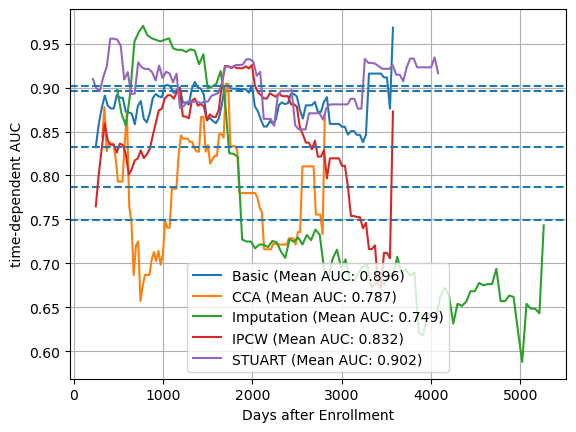

In [25]:
time_dependent_roc(X_train_basic, X_test_basic, y_train_basic, y_test_basic , "Basic")
time_dependent_roc(X_train_CCA, X_testn_CCA, y_trainn_CCA, y_testn_CCA, "CCA")
time_dependent_roc(X_train_IMPUTE, X_test_IMPUTE, y_train_IMPUTE, y_test_IMPUTE, "Imputation")
time_dependent_roc(X_train_IPCW, X_test_IPCW, y_train_IPCW, y_test_IPCW, "IPCW")
time_dependent_roc(X_train_STUART, X_test_STUART, y_train_STUART, y_test_STUART, "STUART")
#STUART
"""times = IB_time_interval(y_train_STUART, y_test_STUART)

    
estimates = final_model.predict_cumulative_hazard_function(X_test_STUART, return_array=False)
estimates_values = np.array([fn(times) for fn in estimates])
y_train_STUART =Surv.from_arrays(time=y_train_STUART['time'], event=y_train_STUART['event'])
y_test_STUART =Surv.from_arrays(time=y_test_STUART['time'], event=y_test_STUART['event'])
auc, mean_auc = cumulative_dynamic_auc(y_train_STUART, y_test_STUART, estimates_values, times)
if np.isnan(mean_auc) or np.isnan(auc).any():
    mean_auc = np.nanmean(auc) 
plt.plot(times, auc, label=f'STUART Mean AUC: {mean_auc:.3f})')"""

#PLot all
plt.xlabel("Days after Enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)
plt.show()

#plot prediction errors

In [26]:
def errors(X_train, X_test,y_train, y_test, model_name ,model=None ):
    if model_name =='IPCW':
        weights = y_train['weights']
    y_train = Surv.from_arrays(event=y_train['event'], time=y_train['time'])
    y_test = Surv.from_arrays(event=y_test['event'], time=y_test['time'])
    if model == None:
        p = X_train.shape[1]
        model = RandomSurvivalForest(random_state=random_state, max_features=p // 3, n_estimators=500)
        if model_name =='IPCW':
            model.fit(X_train, y_train, sample_weight=np.asanyarray(weights))
        else:
            model.fit(X_train, y_train)
        
    survival_functions = model.predict_survival_function(X_test)
    time_points = np.array([sf.x for sf in survival_functions])  # List of time points for predictions
    prediction_errors = np.zeros_like(time_points)  # Array to store errors for each sample at each time point

    # Loop through all samples to calculate prediction errors
    for i, survival_function in enumerate(survival_functions):
        true_event_time = y_test['time'][i]  # Actual event time for the i-th sample
        event_occurred = y_test['event'][i]  # Whether the event occurred (1 if event, 0 if censored)
        
        # Find the predicted survival probability at the true event time (or nearest time point)
        predicted_survival_prob = np.interp(true_event_time, survival_function.x, survival_function.y)
        
        # If the event occurred, the true survival probability is 0 (since the event happened)
        true_survival_prob = 0 if event_occurred == 1 else 1  # For censored data, true survival prob is 1

        # Calculate the prediction error for this sample at the true event time
        prediction_errors[i, :] = np.abs(survival_function.y - true_survival_prob)

    # Now calculate the average prediction error at each time point across all samples
    average_prediction_errors = np.mean(prediction_errors, axis=0)

    # Plot the average prediction error over time
    
    plot = plt.plot(time_points[0], average_prediction_errors, label=model_name)
    return plot
    

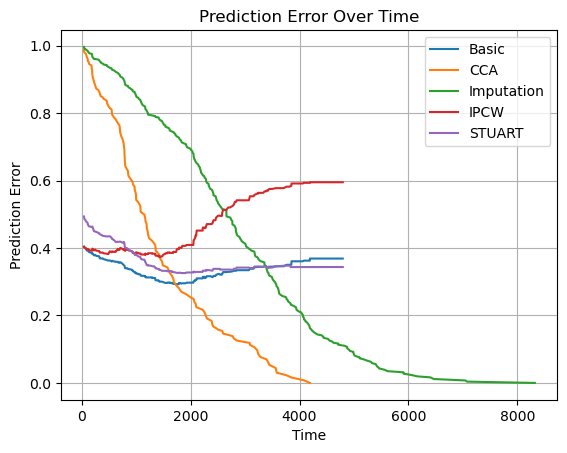

In [27]:
errors(X_train_basic, X_test_basic, y_train_basic, y_test_basic , "Basic")
errors(X_train_CCA, X_testn_CCA, y_trainn_CCA, y_testn_CCA, "CCA")
errors(X_train_IMPUTE, X_test_IMPUTE, y_train_IMPUTE, y_test_IMPUTE, "Imputation")
errors(X_train_IPCW, X_test_IPCW, y_train_IPCW, y_test_IPCW, "IPCW")
errors(X_train_STUART, X_test_STUART, y_train_STUART, y_test_STUART , "STUART")
plt.title("Prediction Error Over Time")
plt.xlabel("Time")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.legend()
plt.show()